<font size="5">Red neuronal en keras para etiquetación de electrocardiogramas (ECG)</font>
<br><br><br>
El objetivo es el de generar y entrenar una red neuronal que aprenda a etiquetar electrocardiogramas. Esta red neuronal es un clasificador que admite como entradas 2000 puntos de un ECG y tantas salidas como etiquetas contenga la base de datos.
<br><br>
En la base de datos considerada (mit-bih-arrythmia-database-1.0.0), 2000 puntos abarcan un periodo de 5.5 segundos (frecuencia de muestreo de 360 Hz). Los electrocardiogramas no son datos en tiempo real, con lo que no hace falta usar una red neuronal recurrente (que se tarda mucho más en entrenar). La red se entrena hasta que el error en validación sea inferior al 5%.
<br><br>
Por otro lado, la red neuronal ha de ser lo suficientemente concisa para que quepa en el Zynq de la PYNQ.
<br><br>

In [1]:
# Importamos las bibliotecas relevantes.

import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import wfdb
from keras import optimizers
from keras.utils import plot_model
from keras.models import load_model, Model
from keras.layers import GaussianNoise, Input, Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

Using TensorFlow backend.


In [2]:
# Localización de los ficheros que contienen los electrocardiogramas y sus anotaciones
# (descargado de physionet.org)

data_path = "mit-bih-arrythmia-database-1.0.0/physionet.org/files/mitdb/1.0.0/"

In [3]:
# Ficheros que queremos leer con los electrocardiogramas y sus anotaciones

pts = ["100", "101", "102", "103", "104", "105", "106", "107", "108", "109", "111", "112", "113", "114", "115", "116", "117", "118", "119", "121", "122", "123", "124", "200", "201", "202", "203", "205", "207", "208", "209", "210", "212", "213", "214", "215", "217", "219", "220", "221", "222", "223", "228", "230", "231", "232", "233", "234"]

In [4]:
# Lectura y parseado de ficheros

df=pd.DataFrame()

for pt in pts:
    file = data_path +  pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym': values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [5]:
# Histograma de las anotaciones contenidas en los ficheros.
# El significado de las anotaciones se explica más abajo.

annotations_histogram = df.groupby('sym').val.sum().sort_values(ascending = False)
print(annotations_histogram)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64


In [6]:
# String		Description
# (AB		Atrial bigeminy
# (AFIB		Atrial fibrillation
# (AFL		Atrial flutter
# (B		Ventricular bigeminy
# (BII		2° heart block
# (IVR		Idioventricular rhythm
# (N		Normal sinus rhythm
# (NOD		Nodal (A-V junctional) rhythm
# (P		Paced rhythm
# (PREX		Pre-excitation (WPW)
# (SBR		Sinus bradycardia
# (SVTA		Supraventricular tachyarrhythmia
# (T		Ventricular trigeminy
# (VFL		Ventricular flutter
# (VT		Ventricular tachycardia

In [7]:
# Non-beat annotations:
# Code		Description
# [		Start of ventricular flutter/fibrillation
# !		Ventricular flutter wave
# ]		End of ventricular flutter/fibrillation
# x		Non-conducted P-wave (blocked APC)
# (		Waveform onset
# )		Waveform end
# p		Peak of P-wave
# t		Peak of T-wave
# u		Peak of U-wave
# `		PQ junction
# '		J-point
# ^		(Non-captured) pacemaker artifact
# |		Isolated QRS-like artifact [1]
# ~		Change in signal quality [1]
# +		Rhythm change [2]
# s		ST segment change [2]
# T		T-wave change [2]
# *		Systole
# D		Diastole
# =		Measurement annotation [2]
# "		Comment annotation [2]
# @		Link to external data [3]

In [8]:
# Beat annotations:
# Code		Description
# N		Normal beat (displayed as "·" by the PhysioBank ATM, LightWAVE, pschart, and psfd)
# L		Left bundle branch block beat
# R		Right bundle branch block beat
# B		Bundle branch block beat (unspecified)
# A		Atrial premature beat
# a		Aberrated atrial premature beat
# J		Nodal (junctional) premature beat
# S		Supraventricular premature or ectopic beat (atrial or nodal)
# V		Premature ventricular contraction
# r		R-on-T premature ventricular contraction
# F		Fusion of ventricular and normal beat
# e		Atrial escape beat
# j		Nodal (junctional) escape beat
# n		Supraventricular escape beat (atrial or nodal)
# E		Ventricular escape beat
# /		Paced beat
# f		Fusion of paced and normal beat
# Q		Unclassifiable beat
# ?		Beat not classified during learning

In [9]:
# De los comentarios anteriores podemos crear un diccionario.

def trad_symbol(x):
    symbol = ["[", "Start of ventricular flutter/fibrillation",
    "!", "Ventricular flutter wave",
    "]", "End of ventricular flutter/fibrillation",
    "x", "Non-conducted P-wave (blocked APC)",
    "(", "Waveform onset",
    ")", "Waveform end",
    "p", "Peak of P-wave",
    "t", "Peak of T-wave",
    "u", "Peak of U-wave",
    "`", "PQ junction",
    "'", "J-point",
    "^", "(Non-captured) pacemaker artifact",
    "|", "Isolated QRS-like artifact [1]",
    "~", "Change in signal quality [1]",
    "+", "Rhythm change [2]",
    "s", "ST segment change [2]",
    "T", "T-wave change [2]",
    "*", "Systole",
    "D", "Diastole",
    "=", "Measurement annotation [2]",
    '"', "Comment annotation [2]",
    "@", "Link to external data [3]",
    "N", "Normal beat (displayed as · by the PhysioBank ATM, LightWAVE, pschart, and psfd)",
    "L", "Left bundle branch block beat",
    "R", "Right bundle branch block beat",
    "B", "Bundle branch block beat (unspecified)",
    "A", "Atrial premature beat",
    "a", "Aberrated atrial premature beat",
    "J", "Nodal (junctional) premature beat",
    "S", "Supraventricular premature or ectopic beat (atrial or nodal)",
    "V", "Premature ventricular contraction",
    "r", "R-on-T premature ventricular contraction",
    "F", "Fusion of ventricular and normal beat",
    "e", "Atrial escape beat",
    "j", "Nodal (junctional) escape beat",
    "n", "Supraventricular escape beat (atrial or nodal)",
    "E", "Ventricular escape beat",
    "/", "Paced beat",
    "f", "Fusion of paced and normal beat",
    "Q", "Unclassifiable beat",
    "?", "Beat not classified during learning"]
    for i in range(int(len(symbol)/2)):
        if x==symbol[i*2]:
            return symbol[i*2 + 1]
    return "Symbol not found"

In [10]:
# Lectura de los electrocardiogramas

def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    
    p_signal = record.p_signal
    
    assert record.fs == 360, 'sample freq is not 360'
    
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [11]:
# Lectura de los ficheros listados

X=[]
Y=[]
def load_data():
    
    # semilongitud de los datos de entrada (trozo de
    # electrocardiograma a ambos lados del latido considerado)
    halfRange=1000
    
    save = 0
    
    firstTime=1
    for pt in pts:
        file = data_path + pt
            
        p_signal, atr_sym, atr_sample = load_ecg(file)
        showPlot=0
        if showPlot == 1:
            plt.plot(p_signal[1:5000,0])
            plt.plot(p_signal[1:5000,1])
            plt.show()
            print(np.array(p_signal).shape)
            print(np.array(p_signal)[:,:])
        x = np.arange(len(p_signal))
        
        
        for a,b in zip(atr_sym, atr_sample):
            line=[]
            if b-halfRange>0 & b+halfRange<len(p_signal):
                u=p_signal[b-halfRange:b+halfRange,0]
                break
                
        if firstTime==1:
            tmp=u.shape[0]
        
        for a,b in zip(atr_sym, atr_sample):
            line=[]
            if b-halfRange>0 & b+halfRange<len(p_signal):
                if save == 1:
                    [line.append(str(i)) for i in p_signal[b-halfRange:b+halfRange,0]]
                    line.append(str(ord(a)))
                    f.write(' '.join(line))
                    f.write('\n')
                else:
                    if p_signal[b-halfRange:b+halfRange,0].shape[0]==tmp:
                        if a=='N':
                            u=p_signal[b-halfRange:b+halfRange,0].reshape(u.shape[0],1)
                            X.append(u)
                            Y.append(ord(a))
                        else:
                            # aumentamos los datos para las etiquetas poco comunes
                            half_ = 1
                            for i in range(half_ * 2 + 1):
                                tmp2 = i - half_
                                u=p_signal[b-halfRange + tmp2:b+halfRange + tmp2,0].reshape(u.shape[0],1)
                                X.append(u)
                                Y.append(ord(a))
                    
    if save == 1:
        f.close()
        return [], []
    else:
        X_full = np.array(X)
        Y_full = np.array(Y)
        print(X_full.shape, Y_full.shape)
        return X_full, Y_full

X_full = []
Y_full = []

X_full, Y_full = load_data()
print(X_full.shape, Y_full.shape)

(187138, 2000, 1) (187138,)
(187138, 2000, 1) (187138,)


In [12]:
num_sec = 3
fs = 360

X_all = X_full.reshape(X_full.shape[0],X_full.shape[1])
Y_all = []
values, counts = np.unique(Y_full, return_counts = True)
values_list=[]

for i in values:
    values_list.append(i)
for i in Y_full:
    Y_all.append(values_list.index(i))
Y_all = np.array(Y_all)

In [13]:
# Separación de datos en dos grupos: validación y entrenamiento

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, train_size=0.67, random_state=42)

In [14]:
values=values_list
print(values)

[33, 34, 43, 47, 65, 69, 70, 74, 76, 78, 81, 82, 83, 86, 91, 93, 97, 101, 102, 106, 120, 124, 126]


In [15]:
# Función para encontrar los divisores de un entero 

def divisorGenerator(n): 
    large_divisors = [] 
    for i in range(1, int(math.sqrt(n) + 1)): 
        if n % i == 0: 
            yield i 
            if i*i != n: 
                large_divisors.append(n / i) 
    for divisor in reversed(large_divisors): 
        yield int(divisor)

In [16]:
# Generación de modelo en keras, api funcional

def gen_model():
    gaussianNoise = 0.21

    shape_divisors = list(divisorGenerator(X_train.shape[1]))

    model_f = [Input(shape=(X_train.shape[1],), name="input")]
    model_f.append(GaussianNoise(gaussianNoise, 
                                 input_shape=(X_train.shape[1],) )(model_f[-1]))
    model_f.append(BatchNormalization()(model_f[-1]))
    divisor_index = 4
    model_f.append( Reshape( (int(X_train.shape[1]/shape_divisors[divisor_index]),
                         shape_divisors[divisor_index], ), 
                       input_shape=(X_train.shape[1],))  (model_f[-1]))
    N = 5
    for i in range(N):
        for j in range(1):
            model_f.append(Conv1D(filters=int(np.power(2,np.power(i,1.2) + 3)),
                                  kernel_size=(j)*2 + 5, activation='elu')(model_f[-1]))

        model_f.append(BatchNormalization()(model_f[-1]))
        model_f.append(MaxPooling1D(pool_size=2)(model_f[-1]))

    model_f.append(Flatten()(model_f[-1]))
    model_f.append(Dense(60, activation='elu')(model_f[-1]))
    model_f.append(BatchNormalization()(model_f[-1]))
    model_f.append(Dense(len(values), activation = 'softmax')(model_f[-1]))

    modelf = Model(inputs=model_f[0],outputs=model_f[-1])
    modelf.summary()


    plot_model(modelf, to_file='model.png', show_shapes=True, show_layer_names=True)
    plt.figure(figsize=(15,60))
    x=plt.imread("model.png")
    plt.imshow(x)
    
    # Compilación del modelo
    modelf.compile(
            optimizer='sgd',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])
    
    return modelf

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2000)              0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2000)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000)              8000      
_________________________________________________________________
reshape_1 (Reshape)          (None, 250, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 8)            328       
_________________________________________________________________
batch_normalization_2 (Batch (None, 246, 8)            32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 123, 8)            0   

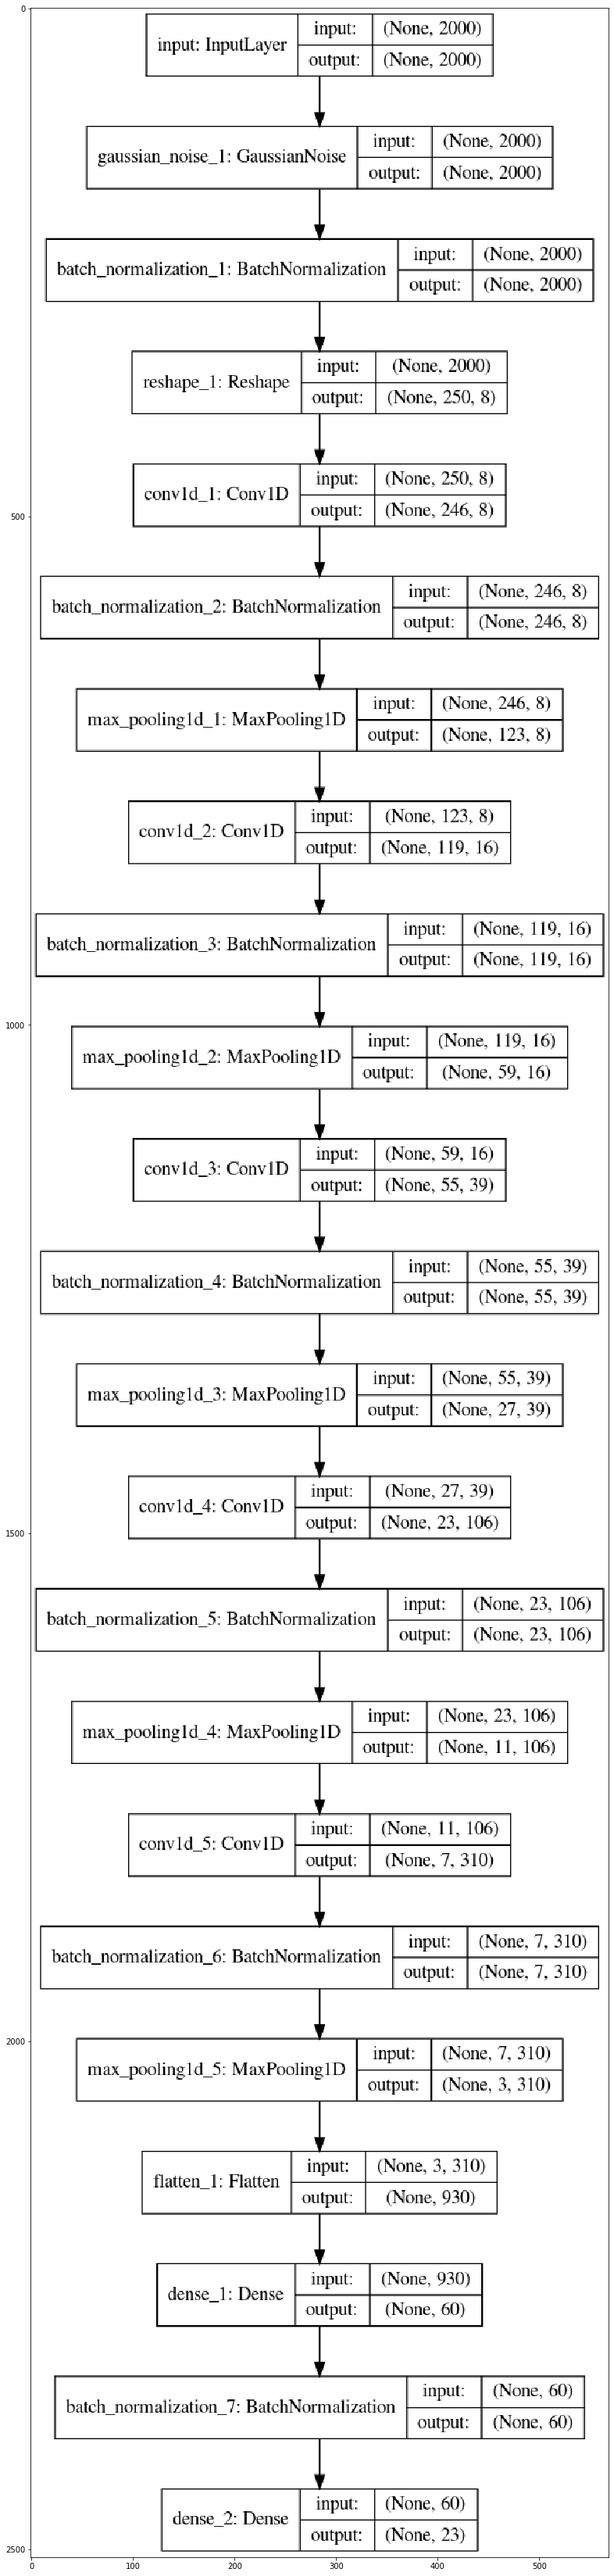

In [17]:
# Declaración del modelo

modelf = []

if False: # si ya tenemos un modelo, podemos reentrenarlo
    modelf = load_model("clasificador_arritmia_version_aumentada.h5")
else:
    modelf = gen_model()

# entrenamiento del modelo
modelf.fit(X_train, y_train, batch_size=64, epochs=1, verbose=1,
              validation_data=(X_valid, y_valid))


In [18]:
# Entrenamiento del modelo por capas

sgd = optimizers.SGD(lr=0.0032180, decay=1.1616e-08, momentum=0.1251, nesterov=True)

modelf.compile(
            optimizer = sgd,
            loss = 'sparse_categorical_crossentropy',
            metrics = ['sparse_categorical_accuracy'])

for i in range(5):
    for l in modelf.layers:
        l.trainable=False
        
    layers_to_train = []
    for i in range(np.random.randint(3,len(modelf.layers))):
        b=np.random.randint(1,len(modelf.layers))
        modelf.layers[b].trainable=True
        layers_to_train.append(b)
        
    print("layers_to_train: ", layers_to_train)
    
    modelf.fit(X_train, y_train, batch_size=2048, epochs=3, verbose=1,
              validation_data=(X_valid, y_valid))
    
    # guardamos la red neuronal
    modelf.save("clasificador_arritmia_version_aumentada.h5")

layers_to_train:  [17, 17, 10, 1, 8]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 125382 samples, validate on 61756 samples
Epoch 1/3
125382/125382 [==============================] - 81s 646us/step - loss: 0.1864 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.1687 - val_sparse_categorical_accuracy: 0.9541
Epoch 2/3
125382/125382 [==============================] - 91s 727us/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9557 - val_loss: 0.1619 - val_sparse_categorical_accuracy: 0.9564
Epoch 3/3
125382/125382 [==============================] - 96s 767us/step - loss: 0.1613 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.1585 - val_sparse_categorical_accuracy: 0.9578
layers_to_train:  [1, 3, 9, 13, 15, 15, 16, 3, 2, 22, 17, 4, 14, 19, 3, 22, 21, 13, 16, 8]
Train on 125382 samples, validate on 61756 samples
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


125382/125382 [==============================] - 95s 756us/step - loss: 0.1561 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.1560 - val_sparse_categorical_accuracy: 0.9585
Epoch 2/3
125382/125382 [==============================] - 95s 757us/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9589 - val_loss: 0.1544 - val_sparse_categorical_accuracy: 0.9588
Epoch 3/3
125382/125382 [==============================] - 95s 761us/step - loss: 0.1521 - sparse_categorical_accuracy: 0.9591 - val_loss: 0.1530 - val_sparse_categorical_accuracy: 0.9593
layers_to_train:  [9, 4, 18, 11, 21]
Train on 125382 samples, validate on 61756 samples
Epoch 1/3
125382/125382 [==============================] - 96s 762us/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9596 - val_loss: 0.1511 - val_sparse_categorical_accuracy: 0.9599
Epoch 2/3
125382/125382 [==============================] - 95s 761us/step - loss: 0.1485 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.1498 - val_sparse_categorical

In [19]:
# Muestra de resultados

y_train_preds_dense = modelf.predict(X_train)
y_valid_preds_dense = modelf.predict(X_valid)
maximum = y_train_preds_dense.max(axis=1)
y_train_preds_dense = np.array([np.where(maximum[i] == y_train_preds_dense[i,:])[0][0] for i in range(maximum.shape[0])])
maximum = y_valid_preds_dense.max(axis=1)
y_valid_preds_dense = np.array([np.where(maximum[i] == y_valid_preds_dense[i,:])[0][0] for i in range(maximum.shape[0])])

print("rms train: ", np.sqrt(np.power(y_train_preds_dense-y_train,2).sum()))
print("rms valid: ", np.sqrt(np.power(y_valid_preds_dense-y_valid,2).sum()))

print("predicciones de entrenamiento:")
print(y_train_preds_dense)
print("error de las predicciones de entrenamiento:")
print(y_train[0:100].astype(int)-y_train_preds_dense[0:100])
print("predicciones de validación:")
print(y_valid_preds_dense)
print("error de las predicciones de validación:")
print(y_valid[0:100].astype(int)-y_valid_preds_dense[0:100])

rms train:  710.9451455632847
rms valid:  504.96930599789926
predicciones de entrenamiento:
[ 9  9  9 ...  8  9 11]
error de las predicciones de entrenamiento:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
predicciones de validación:
[ 3 13  9 ...  8 11  3]
error de las predicciones de validación:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
 -4  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -2  0  7  1  0  0  0  0  0  0  0  0
  0  0  0  0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  


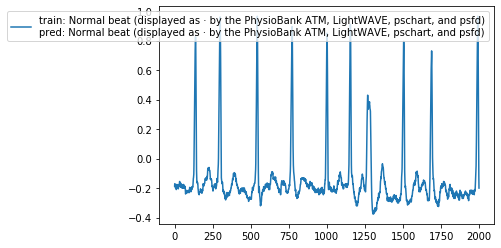

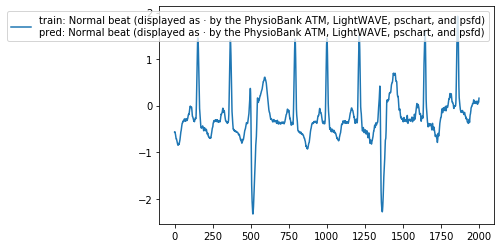

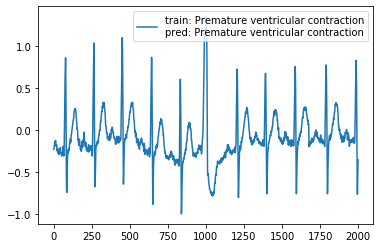

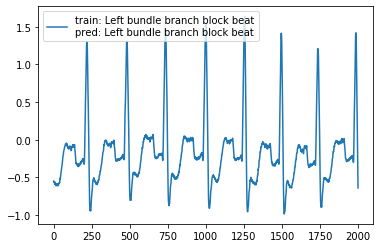

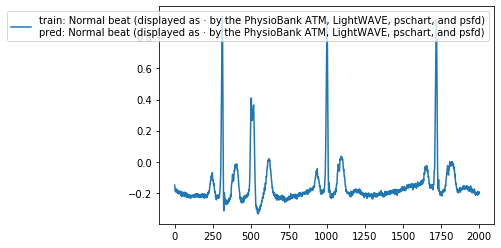

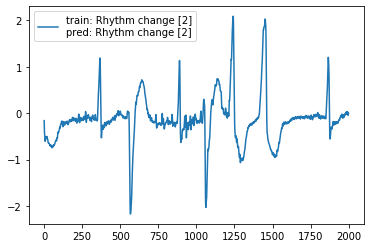

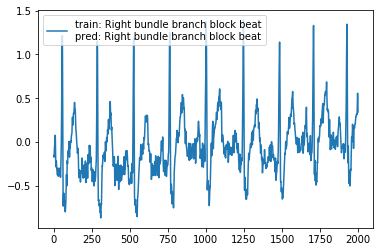

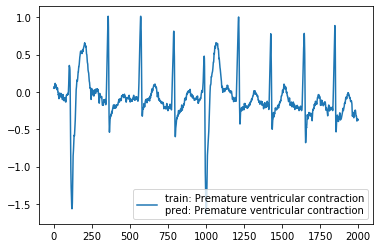

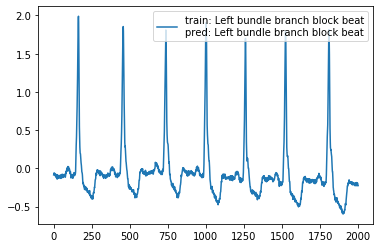

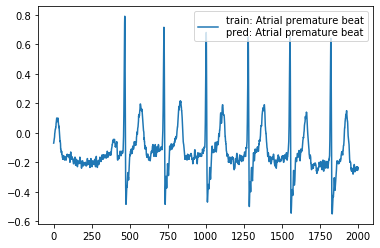

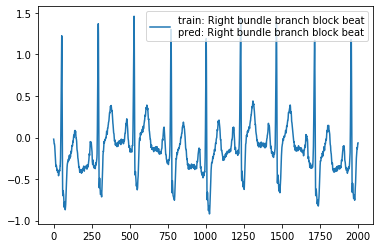

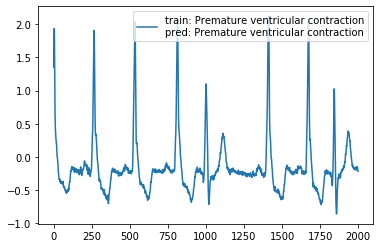

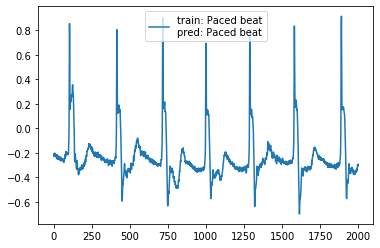

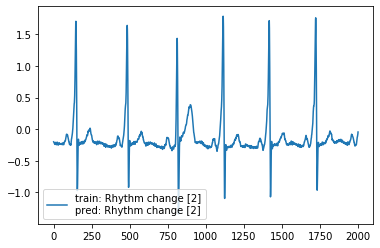

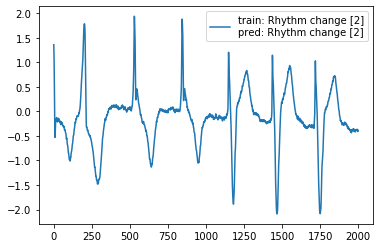

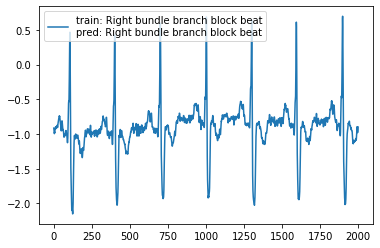

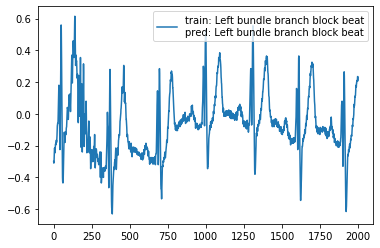

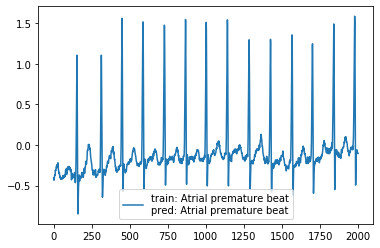

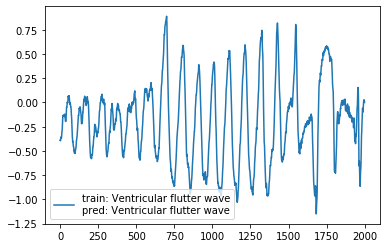

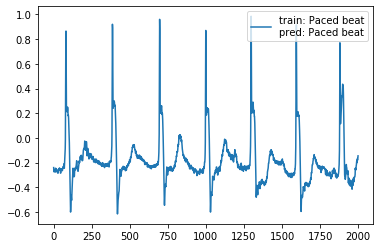

In [20]:
# Gráficas de datos correctamente clasificados en entrenamiento

N_curves_per_category = 3
tt=annotations_histogram.keys()
annotation_values = tt.get_values()
amount_of_curves = (np.zeros(len(tt.get_values())) + N_curves_per_category).astype(int)

k, i = 0, 0
while k < 20:
    i += 1
    if y_train[i].astype(int)==y_train_preds_dense[i] and amount_of_curves[y_train[i].astype(int)] > 0:
        label_ = "train: " + trad_symbol(chr(values_list[int(y_train[i])])) + "\npred: " + trad_symbol(chr(values_list[int(y_train_preds_dense[i])]))
        plt.plot(X_train[i], label=label_)
        plt.legend()

        plt.show()
        k += 1
        amount_of_curves[y_train[i].astype(int)] -= 1

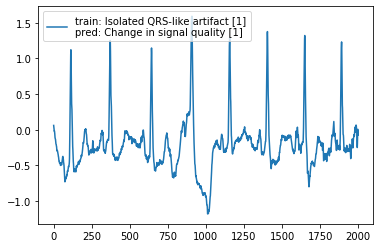

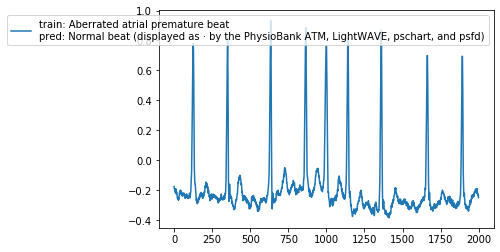

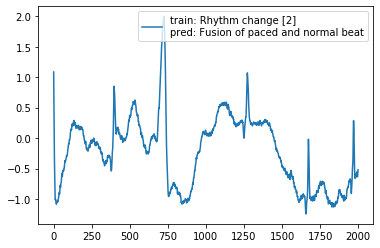

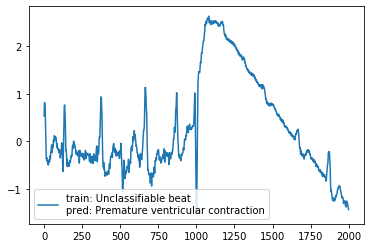

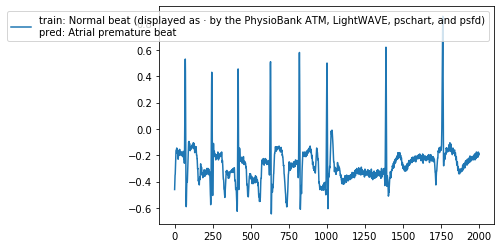

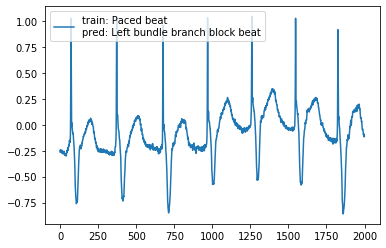

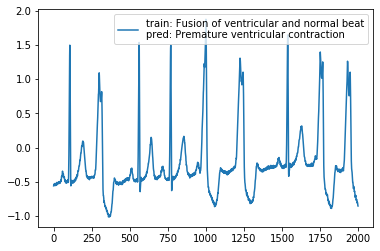

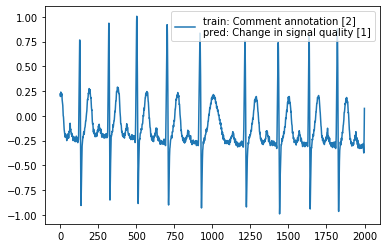

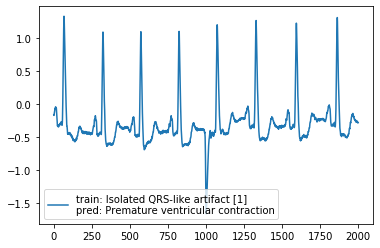

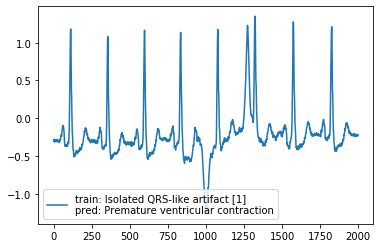

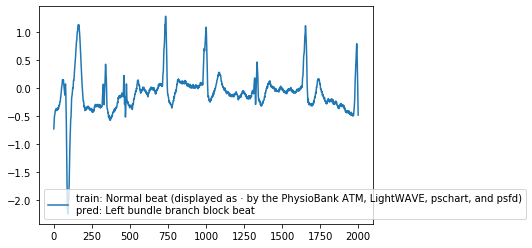

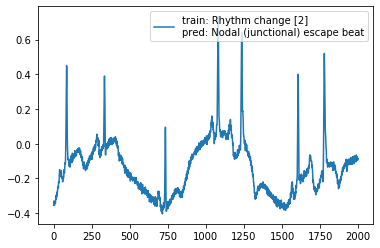

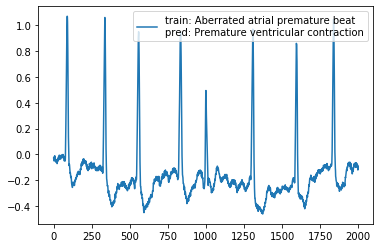

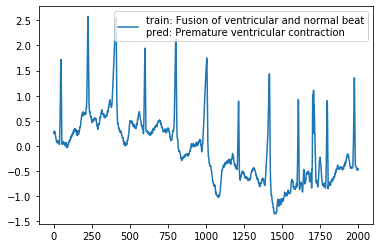

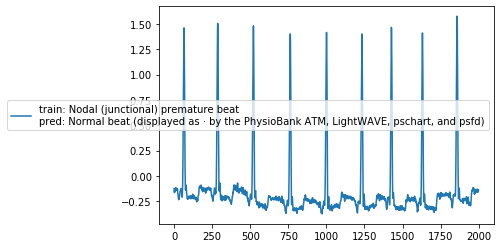

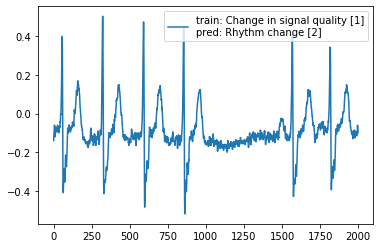

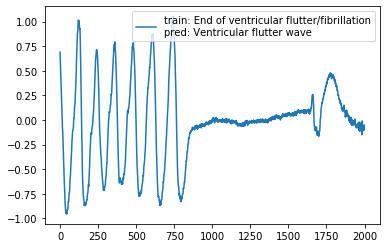

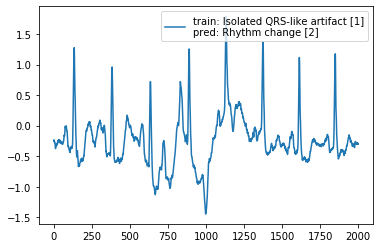

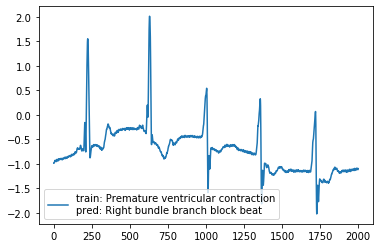

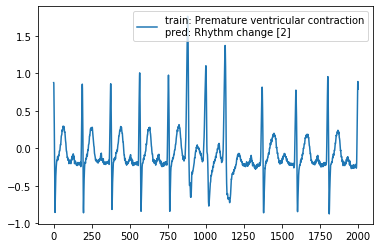

In [21]:
# Gráficas de datos incorrectamente clasificados en entrenamiento

k, i = 0, 0
while k < 20:
    i += 1
    if y_train[i].astype(int)!=y_train_preds_dense[i]:
        label_ = "train: " + trad_symbol(chr(values_list[int(y_train[i])])) + "\npred: " + trad_symbol(chr(values_list[int(y_train_preds_dense[i])]))
        plt.plot(X_train[i], label=label_)
        plt.legend()

        plt.show()
        k += 1

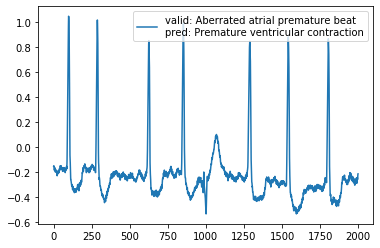

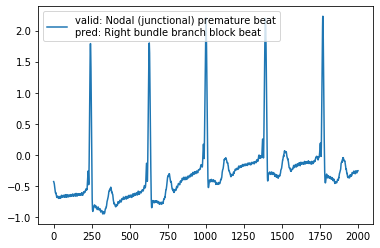

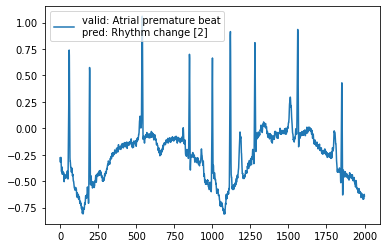

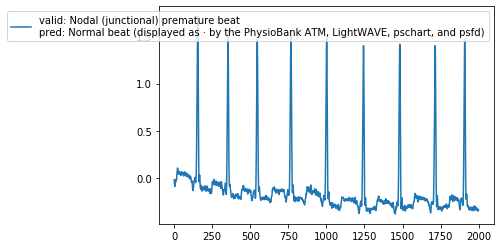

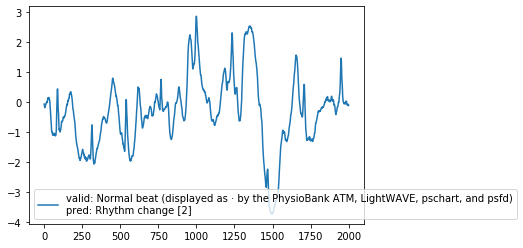

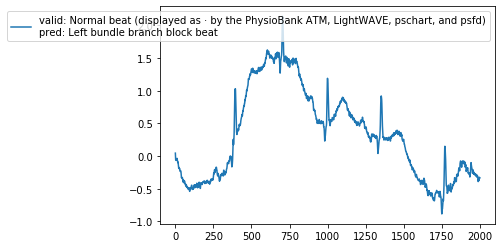

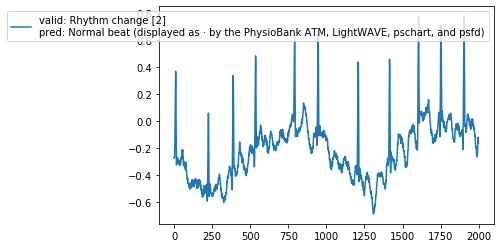

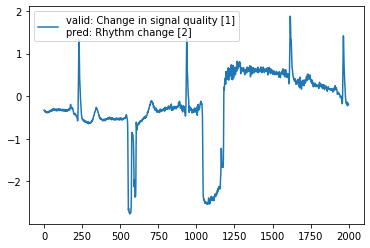

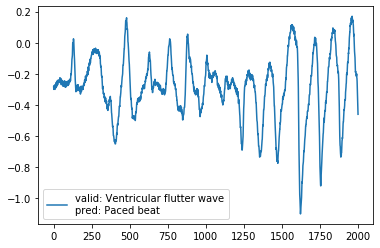

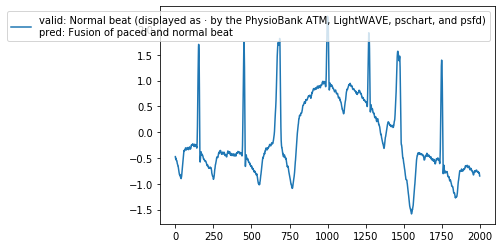

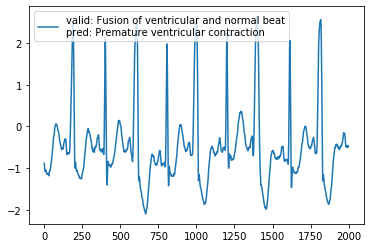

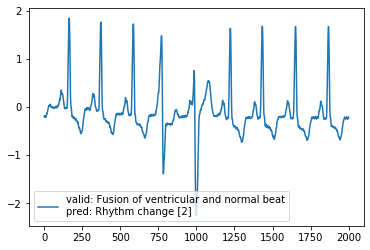

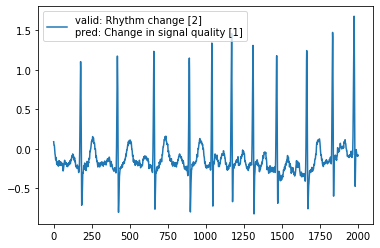

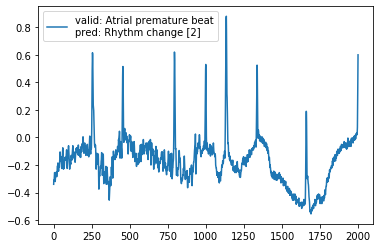

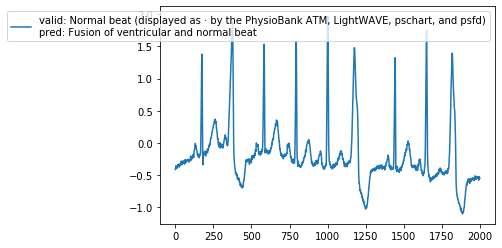

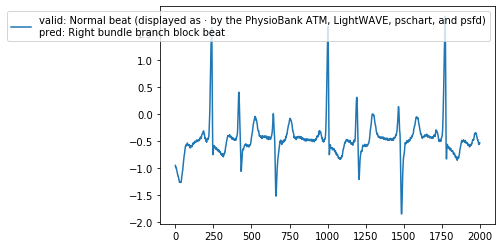

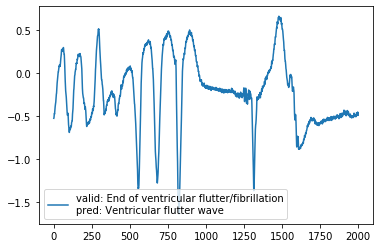

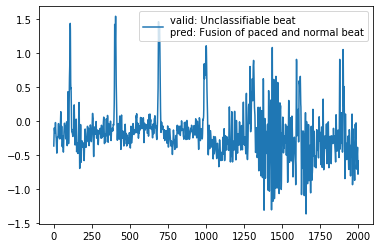

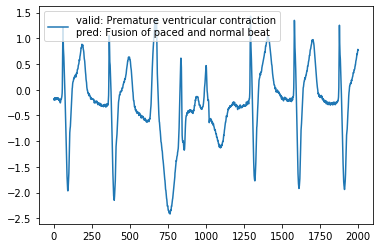

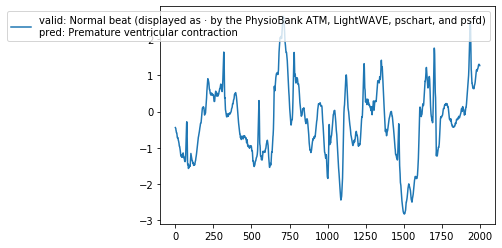

In [22]:
# Gráficas de datos incorrectamente clasificados en validación

k, i = 0, 0
while k < 20:
    i += 1
    if y_valid[i].astype(int)!=y_valid_preds_dense[i]:
        label_ = "valid: " + trad_symbol(chr(values_list[int(y_valid[i])])) + "\npred: " + trad_symbol(chr(values_list[int(y_valid_preds_dense[i])]))
        plt.plot(X_valid[i], label=label_)
        plt.legend()

        plt.show()
        k += 1

In [26]:
# Estadísticas de la clasificación

print("rms train:             ", np.sqrt(np.power(y_train_preds_dense-y_train,2).sum())/len(y_train_preds_dense))
print("rms valid:             ", np.sqrt(np.power(y_valid_preds_dense-y_valid,2).sum())/len(y_valid_preds_dense))
print("total number of beats train: ", y_train_preds_dense.shape[0])
print("total number of beats valid: ", y_valid_preds_dense.shape[0])
print("total number of unknown beats train: ", (y_train_preds_dense!=y_train).astype(int).sum())
print("total number of unknown beats valid: ", (y_valid_preds_dense!=y_valid).astype(int).sum())
print("%error in train:", (y_train_preds_dense!=y_train).astype(int).sum()/y_train_preds_dense.shape[0]*100)
print("%error in valid:", (y_valid_preds_dense!=y_valid).astype(int).sum()/y_valid_preds_dense.shape[0]*100)

rms train:              0.005670232932664056
rms valid:              0.008176846071602748
total number of beats train:  125382
total number of beats valid:  61756
total number of unknown beats train:  4397
total number of unknown beats valid:  2347
%error in train: 3.5068829656569522
%error in valid: 3.800440443033875


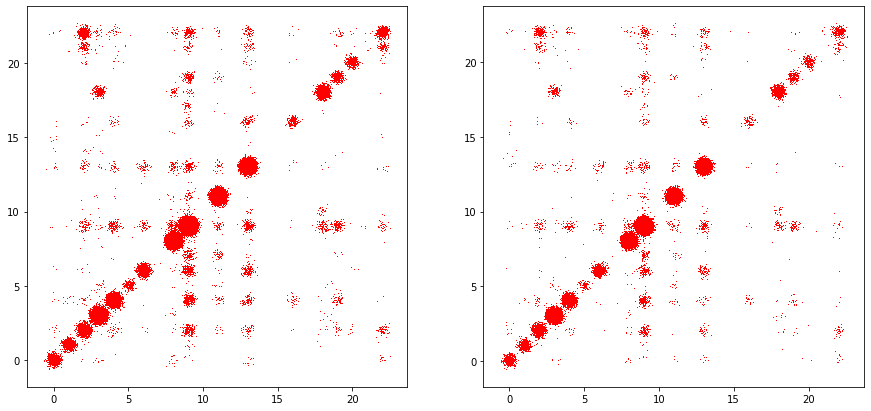

In [24]:
# Representación de datos calculados frente a 
# predichos para los datos de entrenamiento y validación
# (se añade dispersión gausiana en la representación
# para mejorar la visualización)

size_to_plot = y_train.shape[0]
std = 0.2

plt.figure(figsize = (15,7))
plt.subplot(121)
plt.plot(y_train_preds_dense[0:size_to_plot]+np.random.normal(0,std,size_to_plot),
         y_train[0:size_to_plot].astype(int)+np.random.normal(0,std,size_to_plot), 'r,')

size_to_plot = y_valid.shape[0]
plt.subplot(122)
plt.plot(y_valid_preds_dense[0:size_to_plot]+np.random.normal(0,std,size_to_plot),
         y_valid[0:size_to_plot].astype(int)+np.random.normal(0,std,size_to_plot), 'r,')

plt.show()

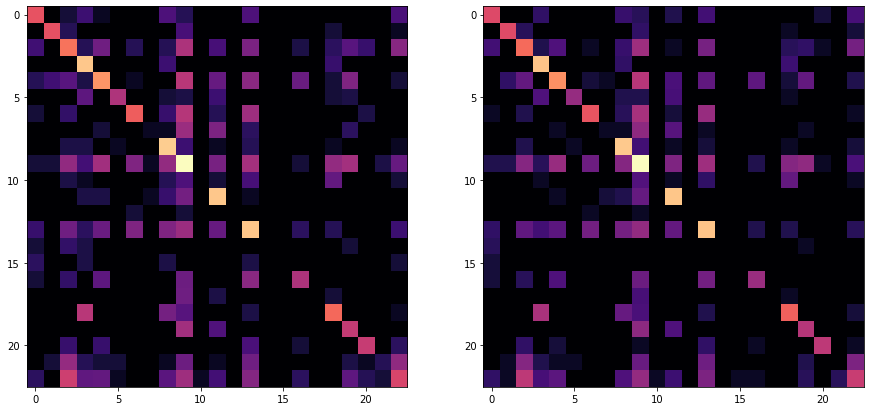

In [25]:
# Matriz de confusión con sklearn
# en escala logarítmica

plt.figure(figsize = (15,7))

cm=metrics.confusion_matrix(y_train, y_train_preds_dense)
plt.subplot(121)
plt.imshow(np.log(cm+1), cmap='magma')

cm=metrics.confusion_matrix(y_valid, y_valid_preds_dense)
plt.subplot(122)
plt.imshow(np.log(cm+1), cmap='magma')


Acknowledgments:

    1) https://towardsdatascience.com/detecting-heart-arrhythmias-with-deep-learning-in-keras-with-dense-cnn-and-lstm-add337d9e41f

    2) physionet.org
